# Load Data

In [1]:
import torch

use_gpu = torch.cuda.is_available()
if use_gpu:
  print("\t\t Using GPU: ", use_gpu)

		 Using GPU:  True


In [177]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import model
import importlib

importlib.reload(model)
import dataset
importlib.reload(dataset)

import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
# import skorch
import os
from time import time

import warnings
warnings.filterwarnings("ignore")

In [77]:
attr_list = [ "RecordID", "Age", "Gender", "Height", "ICUType", "Weight",
                "Albumin", "ALP", "ALT", "AST", "Bilirubin", "BUN", "Cholesterol",
                "Creatinine", "DiasABP", "FiO2", "GCS", "Glucose", "HCO3", "HCT",
                "HR", "K", "Lactate", "Mg", "MAP", "MechVent", "Na", "NIDiasABP",
                "NIMAP", "NISysABP", "PaCO2", "PaO2", "pH", "Platelets", 
                "RespRate", "SaO2", "SysABP", "Temp", "TroponinI", "TroponinT",
                "Urine", "WBC"]

In [78]:
len(attr_list)

42

In [81]:
sum_dict = {}

# Please enter the output and input folder paths here.
input_dir = './setA/'

In [85]:
# functions to process the time in the data
def time_parser(time):
    return pd.to_timedelta(time + ':00')

def time_delta_to_day_figure(timedelta):
    return timedelta.days + (timedelta.seconds/(24*60*60))

In [108]:
def create_DF(df, inputdict, size, id_posistion, split):
    grouped_data = df.groupby('Time')
    
    # Generate input vectors
    x = np.zeros((42, grouped_data.ngroups))
    masking = np.zeros((len(inputdict)-2, grouped_data.ngroups))
    delta = np.zeros((split, size))
    timetable = np.zeros(grouped_data.ngroups)
    ID = 0
    
    all_x = np.zeros((split,1))
    s_dataset = np.zeros((3, split, size))
   
    if grouped_data.ngroups > size:
        # Fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            agg_no = inputdict[value.Parameter]

            # Same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = time_delta_to_day_figure(value.Time)

            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        # Generate index that has most parameters and first/last one.
        ran_index = grouped_data.count()
        ran_index = ran_index.reset_index()
        ran_index = ran_index.sort_values('Value', ascending=False)
        ran_index = ran_index[:size]
        ran_index = ran_index.sort_index()
        ran_index = np.asarray(ran_index.index.values)
        ran_index[0] = 0
        ran_index[size-1] = grouped_data.ngroups-1
        
        # Take ID for outcome comparing
        ID = x[id_posistion, 0]
        
        # Remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        # Column(time) sampling
        x_sample = np.zeros((split, size))
        m_sample = np.zeros((split, size))
        time_sample = np.zeros(size)

        t_x_sample = x_sample.T
        t_marsking = m_sample.T
        
        t_x = x.T
        t_m = masking.T

        it = np.nditer(ran_index, flags=['f_index'])
        while not it.finished:
            t_x_sample[it.index] = t_x[it[0]]
            t_marsking[it.index] = t_m[it[0]]
            time_sample[it.index] = timetable[it[0]]
            it.iternext()
        
        x = x_sample
        masking = m_sample
        timetable = time_sample

        # Fill the delta vectors
        for index, value in np.ndenumerate(masking):
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    
    else:    
        # Fill the x and masking vectors
        pre_time = pd.to_timedelta(0)
        t = 0
        for row_index, value in df.iterrows():
            agg_no = inputdict[value.Parameter]

            # Same timeline check.        
            if pre_time != value.Time:
                pre_time = value.Time
                t += 1
                timetable[t] = time_delta_to_day_figure(value.Time)

            x[agg_no, t] = value.Value    
            masking[agg_no, t] = 1
        
        # Take id for outcome comparing
        ID = x[id_posistion, 0]
        
        # Remove unnesserly parts(rows)
        x = x[:split, :]
        masking = masking[:split, :]
        
        x = np.pad(x, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        masking = np.pad(masking, ((0,0), (size-grouped_data.ngroups, 0)), 'constant')
        timetable = np.pad(timetable, (size-grouped_data.ngroups, 0), 'constant')

        # Fill the delta vectors
        for index, value in np.ndenumerate(masking):
            if index[1] == 0:
                delta[index[0], index[1]] = 0
            elif masking[index[0], index[1]-1] == 0:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1] + delta[index[0], index[1]-1]
            else:
                delta[index[0], index[1]] = timetable[index[1]] - timetable[index[1]-1]
    

    all_x = np.concatenate((all_x, x), axis=1)
    all_x = all_x[:,1:]
    
    s_dataset[0] = x
    
    return s_dataset, all_x, ID

In [109]:
input_feats = {
    "ALP" : 0,             # o
    "ALT" : 1,             # o
    "AST" : 2,             # o
    "Albumin" : 3,         # o
    "BUN" : 4,             # o
    "Bilirubin" : 5,       # o
    "Cholesterol" : 6,     # o
    "Creatinine" : 7,      # o
    "DiasABP" : 8,         # o
    "FiO2" : 9,            # o
    "GCS" : 10,            # o
    "Glucose" : 11,        # o
    "HCO3" : 12,           # o
    "HCT" : 13,            # o
    "HR" : 14,             # o
    "K" : 15,              # o
    "Lactate" : 16,        # o
    "MAP" : 17,            # o
    "Mg" : 18,             # o
    "Na" : 19,             # o
    "PaCO2" : 20,          # o
    "PaO2" : 21,           # o
    "Platelets" : 22,      # o
    "RespRate" : 23,       # o
    "SaO2" : 24,           # o
    "SysABP" : 25,         # o
    "Temp" : 26,           # o
    "Tropl" : 27,          # o
    "TroponinI" : 27,      # temp: regarded same as Tropl
    "TropT" : 28,          # o
    "TroponinT" : 28,      # temp: regarded same as TropT
    "Urine" : 29,          # o
    "WBC" : 30,            # o
    "Weight" : 31,         # o
    "pH" : 32,             # o
    "NIDiasABP" : 33,      # unused variable
    "NIMAP" : 34,          # unused variable
    "NISysABP" : 35,       # unused variable
    "MechVent" : 36,       # unused variable
    "RecordID" : 37,       # unused variable
    "Age" : 38,            # unused variable
    "Gender" :39,          # unused variable
    "ICUType" : 40,        # unused variable
    "Height": 41           # unused variable
}

In [113]:
size = 49 # steps ~ from the paper
id_position = 37
input_length = 42 # input variables ~ from the paper
dataset = np.zeros((4000, input_length, size))

all_x_add = np.zeros((input_length, 1))
i = 0
for filename in os.listdir(input_dir):
    path_file = os.path.join(input_dir, filename)
    df = pd.read_csv(path_file, header=0, parse_dates=['Time'], date_parser=time_parser)
    s_dataset, all_x, ID = create_DF(df=df, inputdict=input_feats, size=size, id_posistion=id_position, split=input_length)
    dataset[i] = s_dataset[0]
    i += 1

print("\t\t Data has shape: ", dataset.shape)

		 Data has shape:  (4000, 42, 49)


In [111]:
np.isnan(dataset).any()

False

In [222]:
# read data
outcomes = pd.read_csv('Outcomes-a.txt')
dataset = np.load("dataset.npy")

In [223]:
outcomes.shape, dataset.shape

((4000, 6), (4000, 3, 33, 49))

In [116]:
# stratified k-fold
num_fold = 10
skf = StratifiedKFold(n_splits=num_fold)

train_dfs, test_dfs = [], []

for train, test in skf.split(outcomes,outcomes['In-hospital_death']):
    train_dfs.append(train)
    test_dfs.append(test)

In [117]:
len(train_dfs), len(test_dfs), len(train_dfs[0]), len(test_dfs[0])

(10, 10, 3600, 400)

In [219]:
import torch.utils.data as utils
from sklearn.model_selection import train_test_split

def get_dataloaders(dataset, outcomes, x_mean, BATCH_SIZE, max_feats=49, test_proportion=0.2):
    train_data, test_data, train_label, test_label = train_test_split(dataset, outcomes, test_size=test_proportion, random_state=42)    
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_label)
    #valid_data, valid_label = torch.Tensor(valid_data), torch.Tensor(valid_label)
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_label)

    train_dataset = utils.TensorDataset(train_data, train_label)
    #valid_dataset = utils.TensorDataset(valid_data, valid_label)
    test_dataset = utils.TensorDataset(test_data, test_label)

    train_dataloader = utils.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
    #valid_dataloader = utils.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle=True)
    test_dataloader = utils.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

    print("\t\t train_dataset: ", train_data.shape)
    print("\t\t test_data: ", test_data.shape)

    x_mean = torch.mean(train_data[:, 0], axis = 0)

    #return train_dataloader, valid_dataloader, test_dataloader, max_feats, x_mean
    return train_dataloader, test_dataloader, max_feats, x_mean                                                   

In [220]:
outcomes['In-hospital_death'].to_numpy()

array([0, 0, 0, ..., 0, 1, 0])

In [224]:
dataset = np.load("dataset.npy")
labels = np.load("y1_out.npy", allow_pickle=True)
print("\t\t labels shape: ", labels.shape)
xmean = np.load("x_mean_aft_nor.npy", allow_pickle=True)
B_SIZE = 32

#train_loader, valid_dataloader, test_loader, max_feats, X_mean = get_dataloaders(dataset, outcomes['In-hospital_death'].to_numpy(), xmean, BATCH_SIZE = B_SIZE)
train_loader, test_loader, max_feats, X_mean = get_dataloaders(dataset, outcomes['In-hospital_death'].to_numpy(), xmean, BATCH_SIZE = B_SIZE)

		 labels shape:  (4000, 1)
		 train_dataset:  torch.Size([3200, 3, 33, 49])
		 test_data:  torch.Size([800, 3, 33, 49])


In [225]:
NUM_FEATURES = 49
batch_size = 32

In [226]:
sum(outcomes['In-hospital_death'] == 0), sum(outcomes['In-hospital_death'] == 1)

(3446, 554)

In [348]:
hidden_size = 64
gru_dropout = 0.3
decoder_dropout = 0.5
output_size = 2

loss_func = torch.nn.NLLLoss(weight=Variable(torch.FloatTensor([1/sum(outcomes['In-hospital_death'] == 0), 
                                       1/sum(outcomes['In-hospital_death'] == 1)
                                      ])).cuda())

num_epochs = 40
log_interval = int((len(train_dfs[0]) / batch_size) / 3)

In [349]:
class GRU_decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size,
              gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
    super(GRU_decoder, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, 
                      batch_first=batch_first, dropout=gru_dropout)
    self.hidden_size = hidden_size
    self.decoder = nn.Sequential(
                                nn.BatchNorm1d(hidden_size),
                                nn.Linear(hidden_size, output_size),
                                nn.LogSoftmax()
                                )
  
  def forward(self, x):
    _, hidden = self.gru(x)
    output = self.decoder(hidden.view(batch_size, self.hidden_size))

    return output

# GRU-mean

In [358]:
def test_model_gru_mean(loader, model, concat_input=False):
    correct, total, total_loss = 0, 0, 0
    model.eval()
    predictions, truths = [], []

    for data, label in loader:
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        output = model(x)
        
        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
            
        total_loss += loss.data
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label)
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [359]:
gru_mean = GRU_decoder(NUM_FEATURES, hidden_size, output_size, gru_dropout, decoder_dropout)
gru_mean.cuda()

optimizer = torch.optim.Adam(gru_mean.parameters(), lr=1e-3)

gru_mean_train_loss_history = []
gru_mean_test_auc_history = []
gru_mean_val_loss_history = []
gru_mean_val_acc_history = []

num_epochs = 40
for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]
        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()
        output = gru_mean(x)
            
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("\t\t\t Epoch %d time: %.4f" % (epoch, time()-start))
        
    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_mean(test_loader, gru_mean)
        gru_mean_train_loss_history.append(total_loss/(i+1))
        gru_mean_test_auc_history.append(test_auc)
        gru_mean_val_acc_history.append(val_acc.cpu().numpy())
        gru_mean_val_loss_history.append(val_loss.cpu().numpy())
        print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k + 1))

			 Epoch 0 time: 0.8133
Epoch: [1/40], Step: [100/100], Loss: 0.7378681749105453, Validation Loss:0.7037290930747986, Validation Acc:60.875, AUC:0.5318041845689455
			 Epoch 1 time: 0.4372
Epoch: [2/40], Step: [100/100], Loss: 0.662702035009861, Validation Loss:0.6929068565368652, Validation Acc:60.625, AUC:0.5473107024184812
			 Epoch 2 time: 0.4350
Epoch: [3/40], Step: [100/100], Loss: 0.6189492759108544, Validation Loss:0.717406690120697, Validation Acc:61.625, AUC:0.5464100098589321
			 Epoch 3 time: 0.4446
Epoch: [4/40], Step: [100/100], Loss: 0.59531692892313, Validation Loss:0.7141612768173218, Validation Acc:58.625, AUC:0.5660913594371888
			 Epoch 4 time: 0.4273
Epoch: [5/40], Step: [100/100], Loss: 0.5577526938915253, Validation Loss:0.7791086435317993, Validation Acc:67.125, AUC:0.555039618301099
			 Epoch 5 time: 0.4252
Epoch: [6/40], Step: [100/100], Loss: 0.5175107634067535, Validation Loss:0.8142654299736023, Validation Acc:65.375, AUC:0.5651054662301148
			 Epoch 6 tim

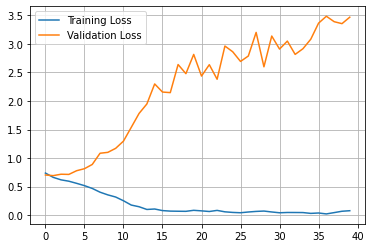

In [360]:
plt.plot(gru_mean_train_loss_history, label="Training Loss")
plt.plot(gru_mean_val_loss_history, label="Validation Loss")
plt.grid()
plt.legend()

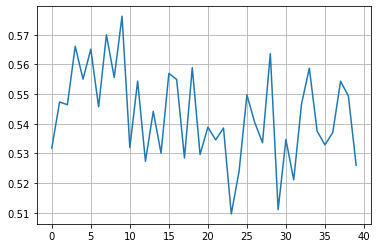

In [361]:
plt.plot(gru_mean_test_auc_history, label="Validation AUC")
plt.grid()

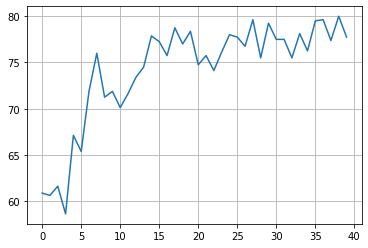

In [362]:
plt.plot(gru_mean_val_acc_history, label="Validation Accuracy")
plt.grid()

In [363]:
print("\t\t Best AUC: ", np.max(gru_mean_test_auc_history))
print("\t\t Best Accuracy:", np.max(gru_mean_val_acc_history))

		 Best AUC:  0.5762302364926545
		 Best Accuracy: 80.0


In [364]:
PATH = "gru_mean_40_EPOCHS"
torch.save(gru_mean.state_dict(), PATH)

# GRU-Simple

In [333]:
def test_model_gru_simple(loader, model, concat_input=False):
    correct, total, total_loss = 0, 0, 0
    model.eval()
    predictions, truths = [], []

    for data, label in loader:
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]
        
        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()
        x[m.data.byte()] = 0.
        
        simple_input = torch.cat([x, m, delta], dim=-1)

        output = model(simple_input)
        
        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
            
        total_loss += loss.item()
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label)
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [334]:
gru_simple_train_loss_histories = []
gru_simple_test_auc_histories = []
gru_simple_val_loss_histories = []
gru_simple_val_acc_histories = []

gru_simple = GRU_decoder(3*NUM_FEATURES, 43, output_size, gru_dropout, decoder_dropout)
gru_simple.cuda()

optimizer = torch.optim.Adam(gru_simple.parameters(), lr=1e-3)

gru_simple_train_loss_history = []
gru_simple_test_auc_history = []
gru_simple_val_loss_history = []
gru_simple_val_acc_history = []

num_epochs = 60

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        x[m.data.byte()] = 0.

        simple_input = torch.cat([x, m, delta], dim=-1)
        optimizer.zero_grad()
        output = gru_simple(simple_input)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_simple(test_loader, gru_simple, concat_input=True)
        gru_simple_train_loss_history.append(total_loss/(i+1))
        gru_simple_test_auc_history.append(test_auc)
        gru_simple_val_acc_history.append(val_acc)
        gru_simple_val_loss_history.append(val_loss)
        print('Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
        epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k + 1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

Epoch: [1/60], Step: [100/100], Loss: 0.7099123948812485, Validation Loss:0.7829305124282837, Validation Acc:80.625, AUC:0.502130016188123
Epoch 0 time: 0.5728
Epoch: [2/60], Step: [100/100], Loss: 0.6674413055181503, Validation Loss:0.6871518135070801, Validation Acc:55.5, AUC:0.5442860794313465
Epoch 1 time: 0.5397
Epoch: [3/60], Step: [100/100], Loss: 0.6499364474415779, Validation Loss:0.7490350770950317, Validation Acc:76.625, AUC:0.5362954758456164
Epoch 2 time: 0.5167
Epoch: [4/60], Step: [100/100], Loss: 0.629411406815052, Validation Loss:0.7991665935516358, Validation Acc:81.375, AUC:0.5472985308974062
Epoch 3 time: 0.7259
Epoch: [5/60], Step: [100/100], Loss: 0.6075600934028625, Validation Loss:0.7309145474433899, Validation Acc:73.0, AUC:0.5760659209581421
Epoch 4 time: 0.7102
Epoch: [6/60], Step: [100/100], Loss: 0.5878670179843902, Validation Loss:0.9181683158874512, Validation Acc:81.25, AUC:0.5261870275928383
Epoch 5 time: 0.6460
Epoch: [7/60], Step: [100/100], Loss: 0.5

Epoch: [52/60], Step: [100/100], Loss: 0.01946721140295267, Validation Loss:4.718521404266357, Validation Acc:79.25, AUC:0.5110091408123273
Epoch 51 time: 0.5651
Epoch: [53/60], Step: [100/100], Loss: 0.036996062949183395, Validation Loss:4.427180938720703, Validation Acc:80.25, AUC:0.5270877201523875
Epoch 52 time: 0.5233
Epoch: [54/60], Step: [100/100], Loss: 0.031238452170509846, Validation Loss:3.7344583320617675, Validation Acc:76.5, AUC:0.5185798269209703
Epoch 53 time: 0.5098
Epoch: [55/60], Step: [100/100], Loss: 0.016596787829184903, Validation Loss:5.3282736825943, Validation Acc:81.875, AUC:0.5264730583381005
Epoch 54 time: 0.5191
Epoch: [56/60], Step: [100/100], Loss: 0.010517239620967303, Validation Loss:4.021675868034363, Validation Acc:77.375, AUC:0.5135469029564624
Epoch 55 time: 0.5096
Epoch: [57/60], Step: [100/100], Loss: 0.046652679932885806, Validation Loss:2.7636247944831847, Validation Acc:65.125, AUC:0.590799547219416
Epoch 56 time: 0.5220
Epoch: [58/60], Step: 

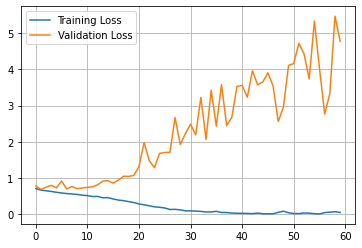

In [335]:
plt.plot(gru_simple_train_loss_history, label="Training Loss")
plt.plot(gru_simple_val_loss_history, label="Validation Loss")
plt.legend()
plt.grid()

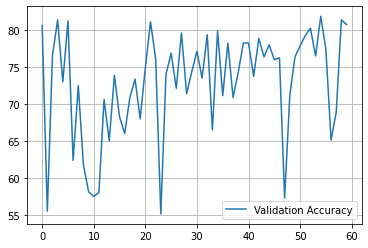

In [336]:
plt.plot(gru_simple_val_acc_history, label="Validation Accuracy")
plt.legend()
plt.grid()

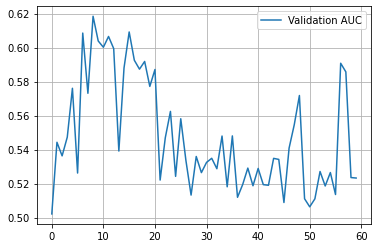

In [337]:
plt.plot(gru_simple_test_auc_history, label="Validation AUC")
plt.legend()
plt.grid()

In [339]:
print("\t\t Best AUC: ", np.max(gru_simple_test_auc_history))
print("\t\t Best Accuracy:", np.max(gru_simple_val_acc_history))

		 Best AUC:  0.6184593288623279
		 Best Accuracy: 81.875


# GRU-D

In [340]:
def test_model_gru_d(loader, model):
    correct, total, total_loss = 0, 0, 0
    model.eval()
    predictions, truths = [], []

    for data, label in loader:
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())

        total_loss += loss.item()
        predicted = (output.cpu().max(1)[1].data.long()).view(-1)
#         predicted = ((output.cpu().data > 0.5).long()).view(-1)
        predictions += list(predicted.numpy())
        truths += list(label.numpy())
        total += label.size(0)
        correct += (predicted == label).sum()

    model.train()

    return 100 * correct / total, roc_auc_score(truths, predictions), total_loss/len(loader)

In [341]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
        
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        self.register_buffer('X_last_obs', torch.zeros(input_size))
        
    def forward(self, x, delta, m, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        
        x_forward = getattr(self, 'X_last_obs')
        
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
            
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_size))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_size,t,:] * h_t[:batch_size])

            z_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_z) + torch.matmul(h_t[:batch_size], self.U_z) + torch.matmul(1-m[:batch_size, t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_r) + torch.matmul(h_t[:batch_size], self.U_r) + torch.matmul(1-m[:batch_size, t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_size, t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_size]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_size, t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_size] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t

In [342]:
gru_d = GRUD(NUM_FEATURES, 49, output_size, gru_dropout, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

In [308]:
import warnings
warnings.filterwarnings("ignore")

gru_d = GRUD(NUM_FEATURES, 49, output_size, 0.0, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

gru_d_train_loss_history = []
gru_d_test_auc_history = []
gru_d_val_loss_history = []
gru_d_val_acc_history = []

num_epochs = 40

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
        gru_d_train_loss_history.append(total_loss/(i+1))
        gru_d_test_auc_history.append(test_auc)
        gru_d_val_acc_history.append(val_acc)
        gru_d_val_loss_history.append(val_loss)
        print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [1/40], Step: [100/100], Loss: 0.7430909860134125, Validation Loss:0.6882704949378967, Validation Acc:53.75, AUC:0.5577477817402842
Epoch 0 time: 7.6832


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [2/40], Step: [100/100], Loss: 0.716322916150093, Validation Loss:0.922138979434967, Validation Acc:15.375, AUC:0.5014727540500736
Epoch 1 time: 7.3840


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [3/40], Step: [100/100], Loss: 0.6955017006397247, Validation Loss:0.6995975637435913, Validation Acc:25.5, AUC:0.5169731861390718
Epoch 2 time: 8.5167


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [4/40], Step: [100/100], Loss: 0.6660863685607911, Validation Loss:0.7870261955261231, Validation Acc:18.125, AUC:0.5142771942209619
Epoch 3 time: 7.3275


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [5/40], Step: [100/100], Loss: 0.6463989061117172, Validation Loss:0.682119586467743, Validation Acc:43.75, AUC:0.5939215423751507
Epoch 4 time: 7.4852


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [6/40], Step: [100/100], Loss: 0.6334826719760894, Validation Loss:0.7172752904891968, Validation Acc:39.875, AUC:0.5676980002190873
Epoch 5 time: 7.1692


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [7/40], Step: [100/100], Loss: 0.6326078003644944, Validation Loss:0.7488023591041565, Validation Acc:79.0, AUC:0.5299115130417849
Epoch 6 time: 8.6085


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [8/40], Step: [100/100], Loss: 0.6116128271818161, Validation Loss:0.751248893737793, Validation Acc:32.375, AUC:0.5574739225160968
Epoch 7 time: 7.6109


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [9/40], Step: [100/100], Loss: 0.603702529668808, Validation Loss:0.716535029411316, Validation Acc:70.0, AUC:0.5787679986367896
Epoch 8 time: 7.0287


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [10/40], Step: [100/100], Loss: 0.5917619073390961, Validation Loss:0.7505280721187592, Validation Acc:73.5, AUC:0.5620321571586802
Epoch 9 time: 7.4865


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [11/40], Step: [100/100], Loss: 0.5851578557491303, Validation Loss:0.8353956580162049, Validation Acc:27.75, AUC:0.5506030988692656
Epoch 10 time: 7.8193


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [12/40], Step: [100/100], Loss: 0.5620607179403305, Validation Loss:0.72853102684021, Validation Acc:60.5, AUC:0.6178872673718034
Epoch 11 time: 7.2894


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [13/40], Step: [100/100], Loss: 0.5466465750336647, Validation Loss:0.7456883430480957, Validation Acc:59.375, AUC:0.5773013303472535
Epoch 12 time: 6.7446


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [14/40], Step: [100/100], Loss: 0.5415660873055458, Validation Loss:1.0382034409046172, Validation Acc:82.125, AUC:0.531341666768096
Epoch 13 time: 8.1536


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [15/40], Step: [100/100], Loss: 0.5240644109249115, Validation Loss:1.2100983357429504, Validation Acc:82.75, AUC:0.5146484256137489
Epoch 14 time: 6.8576


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [16/40], Step: [100/100], Loss: 0.5177662551403046, Validation Loss:0.8250542092323303, Validation Acc:36.75, AUC:0.5560802833530105
Epoch 15 time: 7.5868


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [17/40], Step: [100/100], Loss: 0.4877445477247238, Validation Loss:0.8318317139148712, Validation Acc:61.0, AUC:0.5800825229128884
Epoch 16 time: 8.3578


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [18/40], Step: [100/100], Loss: 0.47617005199193957, Validation Loss:0.9015965580940246, Validation Acc:43.0, AUC:0.5793157170851642
Epoch 17 time: 9.8081


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [19/40], Step: [100/100], Loss: 0.46587734535336495, Validation Loss:0.9539279913902283, Validation Acc:68.75, AUC:0.5272581214474372
Epoch 18 time: 7.2912


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [20/40], Step: [100/100], Loss: 0.4229468084871769, Validation Loss:1.0912826216220857, Validation Acc:74.625, AUC:0.5313051522048711
Epoch 19 time: 7.9021


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [21/40], Step: [100/100], Loss: 0.4309869046509266, Validation Loss:0.9326015198230744, Validation Acc:59.125, AUC:0.5452658868778831
Epoch 20 time: 7.4883


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [22/40], Step: [100/100], Loss: 0.3987829650938511, Validation Loss:1.191419277191162, Validation Acc:38.25, AUC:0.5717085164132961
Epoch 21 time: 7.9286


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [23/40], Step: [100/100], Loss: 0.3939309547841549, Validation Loss:1.3905370652675628, Validation Acc:78.375, AUC:0.5330213366764445
Epoch 22 time: 7.2438


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [24/40], Step: [100/100], Loss: 0.38502537593245506, Validation Loss:1.073565890789032, Validation Acc:46.125, AUC:0.5535790357721004
Epoch 23 time: 7.4328


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [25/40], Step: [100/100], Loss: 0.3745249518752098, Validation Loss:1.5999033081531524, Validation Acc:78.375, AUC:0.5092503560169915
Epoch 24 time: 7.2128


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [26/40], Step: [100/100], Loss: 0.36784681081771853, Validation Loss:1.1008372855186463, Validation Acc:57.5, AUC:0.5424846943122483
Epoch 25 time: 7.3498


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [27/40], Step: [100/100], Loss: 0.31670823737978937, Validation Loss:1.2842015600204468, Validation Acc:41.125, AUC:0.5444990810501589
Epoch 26 time: 7.2644


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [28/40], Step: [100/100], Loss: 0.31141437493264673, Validation Loss:2.064248032569885, Validation Acc:80.0, AUC:0.5120315485826265
Epoch 27 time: 8.7076


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [29/40], Step: [100/100], Loss: 0.2802512861788273, Validation Loss:2.810901947617531, Validation Acc:83.0, AUC:0.505933616524057
Epoch 28 time: 8.4873


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [30/40], Step: [100/100], Loss: 0.29161181055009366, Validation Loss:1.6092887806892395, Validation Acc:70.75, AUC:0.5322484450881826
Epoch 29 time: 7.2941


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [31/40], Step: [100/100], Loss: 0.28192176125943663, Validation Loss:1.4545425951480866, Validation Acc:68.875, AUC:0.527994498472474
Epoch 30 time: 7.3416


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [32/40], Step: [100/100], Loss: 0.24691634371876717, Validation Loss:2.145011337995529, Validation Acc:76.5, AUC:0.5117881181611266
Epoch 31 time: 7.1861


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [33/40], Step: [100/100], Loss: 0.22935455314815045, Validation Loss:1.428994243144989, Validation Acc:63.0, AUC:0.5613018658941809
Epoch 32 time: 9.1815


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [34/40], Step: [100/100], Loss: 0.2069530512019992, Validation Loss:4.128568154573441, Validation Acc:83.875, AUC:0.4975048381796273
Epoch 33 time: 8.5944


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [35/40], Step: [100/100], Loss: 0.20735974818468095, Validation Loss:2.3198210203647616, Validation Acc:72.375, AUC:0.5214462201341302
Epoch 34 time: 7.1200


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [36/40], Step: [100/100], Loss: 0.20509211611002684, Validation Loss:1.8419724249839782, Validation Acc:43.375, AUC:0.5645455762606653
Epoch 35 time: 6.7815


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [37/40], Step: [100/100], Loss: 0.1969827628135681, Validation Loss:3.079007443487644, Validation Acc:81.0, AUC:0.517922564782921
Epoch 36 time: 10.3077


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [38/40], Step: [100/100], Loss: 0.17626042507588863, Validation Loss:4.300078785419464, Validation Acc:83.625, AUC:0.5062196472693192
Epoch 37 time: 7.6654


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [39/40], Step: [100/100], Loss: 0.17114367444068193, Validation Loss:2.1702955067157745, Validation Acc:70.0, AUC:0.5176426197981963
Epoch 38 time: 6.6062


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [40/40], Step: [100/100], Loss: 0.15615724809467793, Validation Loss:2.994278474450111, Validation Acc:78.875, AUC:0.49861244659745124
Epoch 39 time: 6.6968


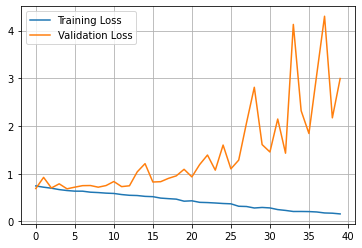

In [309]:
plt.plot(gru_d_train_loss_history, label="Training Loss")
plt.plot(gru_d_val_loss_history, label="Validation Loss")
plt.grid()
plt.legend()

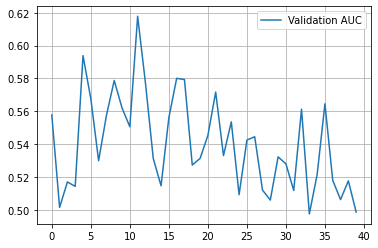

In [310]:
plt.plot(gru_d_test_auc_history, label="Validation AUC")
plt.grid()
plt.legend()

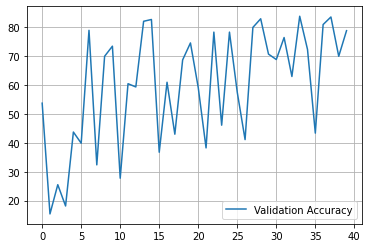

In [311]:
plt.plot(gru_d_val_acc_history, label="Validation Accuracy")
plt.grid()
plt.legend()

In [312]:
print("\t\t Best AUC: %.4f" % np.max(gru_d_test_auc_history))
print("\t\t Best Accuracy: %.4f" % np.max(gru_d_val_acc_history))

		 Best AUC: 0.6179
		 Best Accuracy: 83.8750


In [343]:
import warnings
warnings.filterwarnings("ignore")

gru_d = GRUD(NUM_FEATURES, 49, output_size, 0.0, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

gru_d_train_loss_history = []
gru_d_test_auc_history = []
gru_d_val_loss_history = []
gru_d_val_acc_history = []

num_epochs = 60

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
        gru_d_train_loss_history.append(total_loss/(i+1))
        gru_d_test_auc_history.append(test_auc)
        gru_d_val_acc_history.append(val_acc)
        gru_d_val_loss_history.append(val_loss)
        print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [1/60], Step: [100/100], Loss: 0.7385626202821731, Validation Loss:0.6979743909835815, Validation Acc:19.875, AUC:0.5110030550517898
Epoch 0 time: 7.1931


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [2/60], Step: [100/100], Loss: 0.7044541519880295, Validation Loss:0.6878564858436584, Validation Acc:69.125, AUC:0.5430506700422351
Epoch 1 time: 7.2798


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [3/60], Step: [100/100], Loss: 0.6890504187345505, Validation Loss:0.7303172039985657, Validation Acc:83.125, AUC:0.5270451198286249
Epoch 2 time: 7.4949


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [4/60], Step: [100/100], Loss: 0.6615948849916458, Validation Loss:0.6978635740280151, Validation Acc:34.375, AUC:0.5556725373969985
Epoch 3 time: 9.0912


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [5/60], Step: [100/100], Loss: 0.6387287098169326, Validation Loss:0.6772914481163025, Validation Acc:70.125, AUC:0.5829002300417483
Epoch 4 time: 8.2141


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [6/60], Step: [100/100], Loss: 0.6246029844880104, Validation Loss:0.7650079107284546, Validation Acc:32.75, AUC:0.5528913448313636
Epoch 5 time: 7.3306


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [7/60], Step: [100/100], Loss: 0.6202457356452942, Validation Loss:0.7173916912078857, Validation Acc:36.5, AUC:0.5749826555824682
Epoch 6 time: 8.2384


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [8/60], Step: [100/100], Loss: 0.6048943594098091, Validation Loss:0.6888068068027496, Validation Acc:64.125, AUC:0.6052836572986527
Epoch 7 time: 7.4750


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [9/60], Step: [100/100], Loss: 0.5851999214291572, Validation Loss:0.6907916617393494, Validation Acc:46.625, AUC:0.5836913789116226
Epoch 8 time: 7.1587


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [10/60], Step: [100/100], Loss: 0.5798641309142113, Validation Loss:0.8755638861656189, Validation Acc:78.875, AUC:0.5325709903966699
Epoch 9 time: 7.8839


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [11/60], Step: [100/100], Loss: 0.5567266774177552, Validation Loss:0.8512844288349152, Validation Acc:79.125, AUC:0.5442313075865091
Epoch 10 time: 8.2581


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [12/60], Step: [100/100], Loss: 0.5425805500149727, Validation Loss:0.7524331760406494, Validation Acc:67.5, AUC:0.6013948563151937
Epoch 11 time: 7.9776


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [13/60], Step: [100/100], Loss: 0.5324740394949913, Validation Loss:0.7687186479568482, Validation Acc:75.75, AUC:0.5752869436093428
Epoch 12 time: 7.2402


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [14/60], Step: [100/100], Loss: 0.5062167924642563, Validation Loss:0.7822038304805755, Validation Acc:71.125, AUC:0.5786036831022773
Epoch 13 time: 7.5606


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [15/60], Step: [100/100], Loss: 0.502082241177559, Validation Loss:0.9990364789962769, Validation Acc:31.25, AUC:0.5576382380506092
Epoch 14 time: 8.1900


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [16/60], Step: [100/100], Loss: 0.4669412523508072, Validation Loss:0.8251880955696106, Validation Acc:61.375, AUC:0.5822916539879989
Epoch 15 time: 7.8509


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [17/60], Step: [100/100], Loss: 0.4438564243912697, Validation Loss:1.6859017431735992, Validation Acc:84.375, AUC:0.5072420550396183
Epoch 16 time: 7.3543


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [18/60], Step: [100/100], Loss: 0.43191029205918313, Validation Loss:0.8927120971679687, Validation Acc:52.125, AUC:0.5957168417337115
Epoch 17 time: 7.5903


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [19/60], Step: [100/100], Loss: 0.40794495344161985, Validation Loss:0.9566446459293365, Validation Acc:45.5, AUC:0.5600847137866819
Epoch 18 time: 7.5162


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [20/60], Step: [100/100], Loss: 0.3717084987461567, Validation Loss:1.448277018070221, Validation Acc:27.125, AUC:0.5265460874645504
Epoch 19 time: 7.4363


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [21/60], Step: [100/100], Loss: 0.3563369481265545, Validation Loss:1.071654543876648, Validation Acc:64.625, AUC:0.584458184739347
Epoch 20 time: 7.6220


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [22/60], Step: [100/100], Loss: 0.3489942742884159, Validation Loss:1.6211050057411194, Validation Acc:29.125, AUC:0.5485156830049052
Epoch 21 time: 7.0800


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [23/60], Step: [100/100], Loss: 0.33573990300297735, Validation Loss:1.0281159508228301, Validation Acc:59.0, AUC:0.5547170729926119
Epoch 22 time: 8.3775


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [24/60], Step: [100/100], Loss: 0.3126575108617544, Validation Loss:1.2579071497917176, Validation Acc:45.75, AUC:0.5853284484962086
Epoch 23 time: 7.4593


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [25/60], Step: [100/100], Loss: 0.2824367540329695, Validation Loss:2.2938730823993683, Validation Acc:83.0, AUC:0.5297045971835102
Epoch 24 time: 8.5552


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [26/60], Step: [100/100], Loss: 0.2751077865809202, Validation Loss:3.376774048805237, Validation Acc:84.125, AUC:0.49897759222970095
Epoch 25 time: 7.3683


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [27/60], Step: [100/100], Loss: 0.24132541999220847, Validation Loss:1.4134784889221192, Validation Acc:44.875, AUC:0.5462152655217323
Epoch 26 time: 7.3302


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [28/60], Step: [100/100], Loss: 0.261894323900342, Validation Loss:2.6410435032844544, Validation Acc:84.125, AUC:0.5363319904088415
Epoch 27 time: 7.1954


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [29/60], Step: [100/100], Loss: 0.2304751192778349, Validation Loss:2.0397005546092988, Validation Acc:80.375, AUC:0.5481992234569554
Epoch 28 time: 7.6475


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [30/60], Step: [100/100], Loss: 0.21740323513746262, Validation Loss:3.349491341114044, Validation Acc:83.875, AUC:0.5110882556993147
Epoch 29 time: 7.2498


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [31/60], Step: [100/100], Loss: 0.21586782924830913, Validation Loss:1.6007670736312867, Validation Acc:46.125, AUC:0.5535790357721004
Epoch 30 time: 7.2325


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [32/60], Step: [100/100], Loss: 0.19850345630198718, Validation Loss:2.5975470399856566, Validation Acc:31.75, AUC:0.5503961830109909
Epoch 31 time: 7.4637


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [33/60], Step: [100/100], Loss: 0.16995940502732992, Validation Loss:2.0341049313545225, Validation Acc:78.375, AUC:0.5601881717158194
Epoch 32 time: 7.2203


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [34/60], Step: [100/100], Loss: 0.16648245634511113, Validation Loss:1.640419774055481, Validation Acc:66.75, AUC:0.5664139047456761
Epoch 33 time: 7.2647


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [35/60], Step: [100/100], Loss: 0.14865126326680184, Validation Loss:4.748813500404358, Validation Acc:84.375, AUC:0.5072420550396183
Epoch 34 time: 8.7555


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [36/60], Step: [100/100], Loss: 0.17532671285793186, Validation Loss:2.205209274291992, Validation Acc:43.0, AUC:0.5283779013863362
Epoch 35 time: 9.6026


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [37/60], Step: [100/100], Loss: 0.16213804040104152, Validation Loss:4.2877718806266785, Validation Acc:84.25, AUC:0.5302766586740345
Epoch 36 time: 8.4132


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [38/60], Step: [100/100], Loss: 0.1288411819934845, Validation Loss:2.355296857357025, Validation Acc:75.375, AUC:0.5764736669141542
Epoch 37 time: 8.1944


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [39/60], Step: [100/100], Loss: 0.1337563737295568, Validation Loss:2.6550845658779143, Validation Acc:77.75, AUC:0.5531104322107134
Epoch 38 time: 7.1867


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [40/60], Step: [100/100], Loss: 0.13415691940113902, Validation Loss:2.074411293268204, Validation Acc:74.375, AUC:0.5943536313733128
Epoch 39 time: 7.3836


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [41/60], Step: [100/100], Loss: 0.10611639441922308, Validation Loss:4.192106219530106, Validation Acc:83.625, AUC:0.5265947735488503
Epoch 40 time: 7.3693


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [42/60], Step: [100/100], Loss: 0.13887743909843267, Validation Loss:2.211354320049286, Validation Acc:72.375, AUC:0.5588006183132707
Epoch 41 time: 7.4130


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [43/60], Step: [100/100], Loss: 0.14120432521216572, Validation Loss:2.673222289085388, Validation Acc:36.5, AUC:0.5410241117832495
Epoch 42 time: 7.2475


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [44/60], Step: [100/100], Loss: 0.11609839668497443, Validation Loss:3.7713636541366578, Validation Acc:82.625, AUC:0.5546623011477744
Epoch 43 time: 8.2694


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [45/60], Step: [100/100], Loss: 0.09417424950748682, Validation Loss:2.8971305108070373, Validation Acc:80.125, AUC:0.5704974500663348
Epoch 44 time: 7.1829


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [46/60], Step: [100/100], Loss: 0.07835003648418933, Validation Loss:2.1533012437820434, Validation Acc:55.875, AUC:0.5363076473666913
Epoch 45 time: 7.8049


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [47/60], Step: [100/100], Loss: 0.10283854786306619, Validation Loss:2.047571496963501, Validation Acc:66.5, AUC:0.5921079857349772
Epoch 46 time: 7.2857


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [48/60], Step: [100/100], Loss: 0.08342338129412383, Validation Loss:2.8776652669906615, Validation Acc:78.375, AUC:0.5839591523752723
Epoch 47 time: 7.3136


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [49/60], Step: [100/100], Loss: 0.06457430047448724, Validation Loss:2.676549665927887, Validation Acc:74.375, AUC:0.5773743594737034
Epoch 48 time: 8.9830


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [50/60], Step: [100/100], Loss: 0.08106171214720234, Validation Loss:3.9374879002571106, Validation Acc:82.625, AUC:0.5478705923879307
Epoch 49 time: 7.3620


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [51/60], Step: [100/100], Loss: 0.06977139542810619, Validation Loss:2.9186692094802855, Validation Acc:74.125, AUC:0.5521306247641767
Epoch 50 time: 7.2240


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [52/60], Step: [100/100], Loss: 0.08971809106180445, Validation Loss:3.00422354221344, Validation Acc:74.875, AUC:0.549757178154554
Epoch 51 time: 7.5038


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [53/60], Step: [100/100], Loss: 0.11835101901553571, Validation Loss:3.942315559387207, Validation Acc:80.5, AUC:0.5659148723816014
Epoch 52 time: 7.2373


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [54/60], Step: [100/100], Loss: 0.0843544914596714, Validation Loss:4.920788242816925, Validation Acc:83.625, AUC:0.5333864823086942
Epoch 53 time: 7.4798


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [55/60], Step: [100/100], Loss: 0.07923061774112285, Validation Loss:3.1333411359786987, Validation Acc:71.875, AUC:0.5660426733528889
Epoch 54 time: 7.3714


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [56/60], Step: [100/100], Loss: 0.07075912720174529, Validation Loss:3.029187161922455, Validation Acc:76.125, AUC:0.5774960746844533
Epoch 55 time: 7.1370


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [57/60], Step: [100/100], Loss: 0.06929807575186714, Validation Loss:6.794619789123535, Validation Acc:84.625, AUC:0.5087148090896919
Epoch 56 time: 7.2815


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [58/60], Step: [100/100], Loss: 0.08043814568780362, Validation Loss:2.525311188697815, Validation Acc:57.375, AUC:0.5757068610864299
Epoch 57 time: 7.4936


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [59/60], Step: [100/100], Loss: 0.10124744854168967, Validation Loss:3.554173412322998, Validation Acc:77.375, AUC:0.5610888642753685
Epoch 58 time: 7.3465


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [60/60], Step: [100/100], Loss: 0.10515002130065114, Validation Loss:2.4511568355560303, Validation Acc:74.625, AUC:0.5720554047639334
Epoch 59 time: 7.2268


In [344]:
print("\t\t Best AUC: %.4f" % np.max(gru_d_test_auc_history))
print("\t\t Best Accuracy: %.4f" % np.max(gru_d_val_acc_history))

		 Best AUC: 0.6053
		 Best Accuracy: 84.6250


In [345]:
PATH = "gru_d_60_EPOCHS"
torch.save(gru_d.state_dict(), PATH)

### Decay Functions

$$ decay = 1 - \frac{\exp(-x)}{2} $$

In [377]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
#         self.feature_means = Variable(torch.FloatTensor(feature_means), requires_grad=False)
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        # since W_gamma_x is diagonal, just initialize 1-d
        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        self.register_buffer('X_last_obs', torch.zeros(input_size))
        
    def forward(self, x, delta, m, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        
        x_forward = getattr(self, 'X_last_obs')
        
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        #gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
        gamma_x_t = 1 - torch.exp(-decay_x)/2
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        # gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
        gamma_x_h = 1 - torch.exp(-decay_h) / 2
            
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_size))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_size,t,:] * h_t[:batch_size])

            z_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_z) + torch.matmul(h_t[:batch_size], self.U_z) + torch.matmul(1-m[:batch_size, t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_r) + torch.matmul(h_t[:batch_size], self.U_r) + torch.matmul(1-m[:batch_size, t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_size, t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_size]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_size, t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_size] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t

In [378]:
gru_d = GRUD(NUM_FEATURES, 49, output_size, gru_dropout, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

In [379]:
import warnings
warnings.filterwarnings("ignore")

gru_d = GRUD(NUM_FEATURES, 49, output_size, 0.0, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

gru_d_train_loss_history = []
gru_d_test_auc_history = []
gru_d_val_loss_history = []
gru_d_val_acc_history = []

num_epochs = 60

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
        gru_d_train_loss_history.append(total_loss/(i+1))
        gru_d_test_auc_history.append(test_auc)
        gru_d_val_acc_history.append(val_acc)
        gru_d_val_loss_history.append(val_loss)
        print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [1/60], Step: [100/100], Loss: 0.7652787190675735, Validation Loss:0.7159079813957214, Validation Acc:80.875, AUC:0.5273737508976497
Epoch 0 time: 7.3007


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [2/60], Step: [100/100], Loss: 0.7082026475667953, Validation Loss:0.6863204860687255, Validation Acc:55.25, AUC:0.5462091797611948
Epoch 1 time: 7.3356


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [3/60], Step: [100/100], Loss: 0.6791605621576309, Validation Loss:0.6914980030059814, Validation Acc:65.25, AUC:0.5439939629255468
Epoch 2 time: 7.6794


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [4/60], Step: [100/100], Loss: 0.6784833836555481, Validation Loss:0.6909754323959351, Validation Acc:43.5, AUC:0.5550943901459365
Epoch 3 time: 7.2736


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [5/60], Step: [100/100], Loss: 0.6732014954090119, Validation Loss:0.6880886673927307, Validation Acc:46.5, AUC:0.5320171861877578
Epoch 4 time: 8.1280


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [6/60], Step: [100/100], Loss: 0.6684445172548295, Validation Loss:0.6970279836654663, Validation Acc:65.875, AUC:0.5476758480507309
Epoch 5 time: 7.6961


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [7/60], Step: [100/100], Loss: 0.6557257264852524, Validation Loss:0.6932034349441528, Validation Acc:34.875, AUC:0.5416387735975365
Epoch 6 time: 7.2850


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [8/60], Step: [100/100], Loss: 0.646804436147213, Validation Loss:0.6958665180206299, Validation Acc:50.375, AUC:0.585407563383196
Epoch 7 time: 7.8441


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [9/60], Step: [100/100], Loss: 0.6408622616529465, Validation Loss:0.7136116600036622, Validation Acc:73.125, AUC:0.5326561910441948
Epoch 8 time: 7.8710


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [10/60], Step: [100/100], Loss: 0.6343777289986611, Validation Loss:0.6982470440864563, Validation Acc:45.625, AUC:0.5404459645321875
Epoch 9 time: 7.3991


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [11/60], Step: [100/100], Loss: 0.6334532338380814, Validation Loss:0.7142853331565857, Validation Acc:64.625, AUC:0.5471037865602064
Epoch 10 time: 7.2250


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [12/60], Step: [100/100], Loss: 0.6196450734138489, Validation Loss:0.7105054569244384, Validation Acc:47.25, AUC:0.5398313027179007
Epoch 11 time: 8.6954


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [13/60], Step: [100/100], Loss: 0.6130996999144555, Validation Loss:0.7262645888328553, Validation Acc:42.875, AUC:0.5344332331211432
Epoch 12 time: 9.1978


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [14/60], Step: [100/100], Loss: 0.6160178691148758, Validation Loss:0.7128239488601684, Validation Acc:63.125, AUC:0.5450589710196083
Epoch 13 time: 7.4620


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [15/60], Step: [100/100], Loss: 0.6015407600998879, Validation Loss:0.8153737211227416, Validation Acc:76.0, AUC:0.5258218819605887
Epoch 14 time: 7.5931


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [16/60], Step: [100/100], Loss: 0.6028526493906975, Validation Loss:0.7230510878562927, Validation Acc:49.375, AUC:0.5489538577636047
Epoch 15 time: 7.3147


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [17/60], Step: [100/100], Loss: 0.5849584418535233, Validation Loss:0.7258039712905884, Validation Acc:61.875, AUC:0.5784454533283024
Epoch 16 time: 7.3924


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [18/60], Step: [100/100], Loss: 0.587307376563549, Validation Loss:0.8085343325138092, Validation Acc:73.875, AUC:0.5234910356747283
Epoch 17 time: 8.4020


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [19/60], Step: [100/100], Loss: 0.5860412320494652, Validation Loss:0.9769285929203033, Validation Acc:81.25, AUC:0.5261870275928383
Epoch 18 time: 7.7293


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [20/60], Step: [100/100], Loss: 0.5707263380289078, Validation Loss:0.7459357523918152, Validation Acc:65.375, AUC:0.5718971749899585
Epoch 19 time: 7.3392


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [21/60], Step: [100/100], Loss: 0.5602318951487542, Validation Loss:0.7967024230957032, Validation Acc:35.875, AUC:0.5679049160773622
Epoch 20 time: 7.4255


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [22/60], Step: [100/100], Loss: 0.5509207639098167, Validation Loss:0.7629700803756714, Validation Acc:61.5, AUC:0.5694446134933482
Epoch 21 time: 7.3890


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [23/60], Step: [100/100], Loss: 0.5480730083584785, Validation Loss:0.9974823188781738, Validation Acc:78.25, AUC:0.5187015421317202
Epoch 22 time: 7.6320


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [24/60], Step: [100/100], Loss: 0.5491576051712036, Validation Loss:1.344751673936844, Validation Acc:84.125, AUC:0.5091651553694665
Epoch 23 time: 7.7320


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [25/60], Step: [100/100], Loss: 0.5316974079608917, Validation Loss:0.928890620470047, Validation Acc:78.5, AUC:0.5371535680814031
Epoch 24 time: 7.3899


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [26/60], Step: [100/100], Loss: 0.5213025861978531, Validation Loss:0.7793919444084167, Validation Acc:66.0, AUC:0.5857666232549081
Epoch 25 time: 8.7868


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [27/60], Step: [100/100], Loss: 0.5217460712790489, Validation Loss:0.8187284278869629, Validation Acc:72.0, AUC:0.5803624678976133
Epoch 26 time: 7.9242


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [28/60], Step: [100/100], Loss: 0.503961524516344, Validation Loss:0.9583447289466858, Validation Acc:75.625, AUC:0.5643630034445404
Epoch 27 time: 7.4129


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [29/60], Step: [100/100], Loss: 0.49093701407313345, Validation Loss:0.8168035769462585, Validation Acc:66.0, AUC:0.5789749144950644
Epoch 28 time: 8.6853


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [30/60], Step: [100/100], Loss: 0.489458435177803, Validation Loss:0.9710593116283417, Validation Acc:76.125, AUC:0.5741002203045316
Epoch 29 time: 8.8396


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [31/60], Step: [100/100], Loss: 0.47405531018972397, Validation Loss:1.0008264887332916, Validation Acc:77.375, AUC:0.5780681361749779
Epoch 30 time: 8.4378


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [32/60], Step: [100/100], Loss: 0.47333630442619323, Validation Loss:0.8561661744117737, Validation Acc:49.375, AUC:0.5557455665234484
Epoch 31 time: 9.9360


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [33/60], Step: [100/100], Loss: 0.4360384783148766, Validation Loss:1.3067362606525421, Validation Acc:80.5, AUC:0.5217687654426174
Epoch 32 time: 8.4191


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [34/60], Step: [100/100], Loss: 0.42588699609041214, Validation Loss:1.149632580280304, Validation Acc:30.125, AUC:0.523844009785903
Epoch 33 time: 8.2383


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [35/60], Step: [100/100], Loss: 0.4173832996189594, Validation Loss:0.9431137537956238, Validation Acc:50.25, AUC:0.5473167881790187
Epoch 34 time: 7.3332


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [36/60], Step: [100/100], Loss: 0.3920871567726135, Validation Loss:1.0748401880264282, Validation Acc:39.75, AUC:0.5431906425345976
Epoch 35 time: 7.7273


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [37/60], Step: [100/100], Loss: 0.38231280490756037, Validation Loss:1.085138317346573, Validation Acc:70.125, AUC:0.5727126669019827
Epoch 36 time: 7.2979


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [38/60], Step: [100/100], Loss: 0.3637998668849468, Validation Loss:1.3282948780059813, Validation Acc:41.0, AUC:0.5437627040251221
Epoch 37 time: 7.3230


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [39/60], Step: [100/100], Loss: 0.34809164389967917, Validation Loss:1.057276668548584, Validation Acc:58.625, AUC:0.5762789225769545
Epoch 38 time: 10.4728


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [40/60], Step: [100/100], Loss: 0.32945685654878615, Validation Loss:1.5441540443897248, Validation Acc:78.25, AUC:0.5356808140313295
Epoch 39 time: 7.6947


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [41/60], Step: [100/100], Loss: 0.3209871692955494, Validation Loss:1.4185861492156981, Validation Acc:35.375, AUC:0.5445842816976838
Epoch 40 time: 7.7854


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [42/60], Step: [100/100], Loss: 0.2927164867520332, Validation Loss:1.4012287425994874, Validation Acc:34.75, AUC:0.5476941053323434
Epoch 41 time: 7.2777


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [43/60], Step: [100/100], Loss: 0.2882103592902422, Validation Loss:1.9635405814647675, Validation Acc:79.75, AUC:0.5207463576723182
Epoch 42 time: 7.3995


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [44/60], Step: [100/100], Loss: 0.26272743292152884, Validation Loss:1.2999121022224427, Validation Acc:59.5, AUC:0.5542667267128374
Epoch 43 time: 8.4679


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [45/60], Step: [100/100], Loss: 0.25108359385281803, Validation Loss:1.6150316071510316, Validation Acc:74.875, AUC:0.5531530325344759
Epoch 44 time: 8.1520


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [46/60], Step: [100/100], Loss: 0.24056790381669999, Validation Loss:1.649257674217224, Validation Acc:69.625, AUC:0.5527878869022261
Epoch 45 time: 7.2980


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [47/60], Step: [100/100], Loss: 0.2249022614583373, Validation Loss:1.5823793697357178, Validation Acc:64.375, AUC:0.5558185956498983
Epoch 46 time: 7.3565


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [48/60], Step: [100/100], Loss: 0.2130427228100598, Validation Loss:2.4905697858333586, Validation Acc:79.625, AUC:0.5200099806472814
Epoch 47 time: 7.3328


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [49/60], Step: [100/100], Loss: 0.20276824317872524, Validation Loss:1.508703546524048, Validation Acc:57.375, AUC:0.5553317348068988
Epoch 48 time: 7.3057


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [50/60], Step: [100/100], Loss: 0.2099210449680686, Validation Loss:2.781856880187988, Validation Acc:81.0, AUC:0.5247142735427647
Epoch 49 time: 7.9169


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [51/60], Step: [100/100], Loss: 0.1674728861451149, Validation Loss:1.7026232528686522, Validation Acc:65.0, AUC:0.5255419369758638
Epoch 50 time: 8.4039


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [52/60], Step: [100/100], Loss: 0.1638748389482498, Validation Loss:2.7116061985492705, Validation Acc:79.25, AUC:0.517800849572171
Epoch 51 time: 7.4168


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [53/60], Step: [100/100], Loss: 0.1474445276707411, Validation Loss:3.9511515212059023, Validation Acc:81.875, AUC:0.48911866015896005
Epoch 52 time: 7.4988


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [54/60], Step: [100/100], Loss: 0.15452386166900398, Validation Loss:2.8625648117065428, Validation Acc:79.25, AUC:0.517800849572171
Epoch 53 time: 7.1889


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [55/60], Step: [100/100], Loss: 0.13275002389214932, Validation Loss:4.10639199256897, Validation Acc:82.125, AUC:0.5007789773487993
Epoch 54 time: 7.0575


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [56/60], Step: [100/100], Loss: 0.12459307953715325, Validation Loss:2.2828292655944824, Validation Acc:67.875, AUC:0.5390827541717889
Epoch 55 time: 7.5237


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [57/60], Step: [100/100], Loss: 0.14067409973591566, Validation Loss:6.786064796447754, Validation Acc:84.125, AUC:0.4955817378497791
Epoch 56 time: 7.3775


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [58/60], Step: [100/100], Loss: 0.16910492775961758, Validation Loss:2.604955230951309, Validation Acc:76.125, AUC:0.5469333852651566
Epoch 57 time: 8.6617


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [59/60], Step: [100/100], Loss: 0.1470612141583115, Validation Loss:4.44442126750946, Validation Acc:81.75, AUC:0.495173991893767
Epoch 58 time: 8.7367


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [60/60], Step: [100/100], Loss: 0.09882479574531317, Validation Loss:3.520203056335449, Validation Acc:79.375, AUC:0.49476624593775487
Epoch 59 time: 8.4386


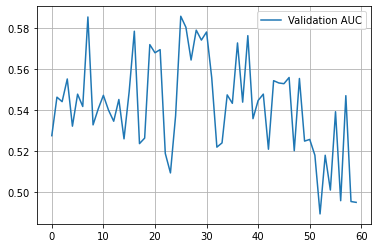

In [380]:
plt.plot(gru_d_test_auc_history, label="Validation AUC")
plt.grid()
plt.legend()

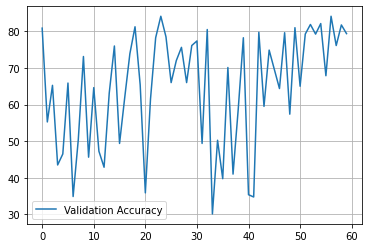

In [381]:
plt.plot(gru_d_val_acc_history, label="Validation Accuracy")
plt.grid()
plt.legend()

In [382]:
print("\t\t Best AUC: %.4f" % np.max(gru_d_test_auc_history))
print("\t\t Best Accuracy: %.4f" % np.max(gru_d_val_acc_history))

		 Best AUC: 0.5858
		 Best Accuracy: 84.1250


$$ Sigmoid = \frac{1}{1 + \exp(-x)} $$

In [383]:
class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
#         self.feature_means = Variable(torch.FloatTensor(feature_means), requires_grad=False)
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        # since W_gamma_x is diagonal, just initialize 1-d
        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        self.register_buffer('X_last_obs', torch.zeros(input_size))
        
    def forward(self, x, delta, m, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        
        x_forward = getattr(self, 'X_last_obs')
        
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        #gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
        gamma_x_t = F.sigmoid(decay_x)
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        # gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
        gamma_x_h = F.sigmoid(decay_h)
            
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_size))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_size,t,:] * h_t[:batch_size])

            z_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_z) + torch.matmul(h_t[:batch_size], self.U_z) + torch.matmul(1-m[:batch_size, t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_r) + torch.matmul(h_t[:batch_size], self.U_r) + torch.matmul(1-m[:batch_size, t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_size, t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_size]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_size, t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_size] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t

In [384]:
import warnings
warnings.filterwarnings("ignore")

gru_d = GRUD(NUM_FEATURES, 49, output_size, 0.0, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

gru_d_train_loss_history = []
gru_d_test_auc_history = []
gru_d_val_loss_history = []
gru_d_val_acc_history = []

num_epochs = 60

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
        gru_d_train_loss_history.append(total_loss/(i+1))
        gru_d_test_auc_history.append(test_auc)
        gru_d_val_acc_history.append(val_acc)
        gru_d_val_loss_history.append(val_loss)
        print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [1/60], Step: [100/100], Loss: 0.7749748957157135, Validation Loss:0.7295997762680053, Validation Acc:25.25, AUC:0.5256879952287637
Epoch 0 time: 8.1222


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [2/60], Step: [100/100], Loss: 0.7068215954303741, Validation Loss:0.8014087963104248, Validation Acc:16.0, AUC:0.5051546391752577
Epoch 1 time: 7.2985


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [3/60], Step: [100/100], Loss: 0.6918519020080567, Validation Loss:0.7239907264709473, Validation Acc:82.125, AUC:0.5347375211480179
Epoch 2 time: 7.2411


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [4/60], Step: [100/100], Loss: 0.6916119891405106, Validation Loss:0.683699038028717, Validation Acc:51.5, AUC:0.5716598303289963
Epoch 3 time: 7.1669


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [5/60], Step: [100/100], Loss: 0.6706063556671142, Validation Loss:0.709322144985199, Validation Acc:73.75, AUC:0.5261505130296132
Epoch 4 time: 7.2183


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [6/60], Step: [100/100], Loss: 0.6688707000017167, Validation Loss:0.6954091930389404, Validation Acc:42.375, AUC:0.5246960162611521
Epoch 5 time: 7.0407


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [7/60], Step: [100/100], Loss: 0.6685576945543289, Validation Loss:0.7082192540168762, Validation Acc:74.875, AUC:0.522590343115179
Epoch 6 time: 11.2118


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [8/60], Step: [100/100], Loss: 0.6456257706880569, Validation Loss:0.6957305335998535, Validation Acc:68.125, AUC:0.5541389257415499
Epoch 7 time: 8.6011


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [9/60], Step: [100/100], Loss: 0.6498307359218597, Validation Loss:0.7785612416267395, Validation Acc:82.5, AUC:0.5335507978432065
Epoch 8 time: 8.8237


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [10/60], Step: [100/100], Loss: 0.6490558671951294, Validation Loss:0.7795264387130737, Validation Acc:79.625, AUC:0.5268016894071252
Epoch 9 time: 8.3749


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [11/60], Step: [100/100], Loss: 0.64316291898489, Validation Loss:0.7056174421310425, Validation Acc:48.5, AUC:0.5539867817281126
Epoch 10 time: 8.6711


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [12/60], Step: [100/100], Loss: 0.6369323128461838, Validation Loss:0.7048925614356994, Validation Acc:44.5, AUC:0.5507978432064655
Epoch 11 time: 8.5748


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [13/60], Step: [100/100], Loss: 0.6340189990401268, Validation Loss:0.7118085789680481, Validation Acc:66.125, AUC:0.5491486021008045
Epoch 12 time: 8.7965


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [14/60], Step: [100/100], Loss: 0.6231514325737953, Validation Loss:0.7184684634208679, Validation Acc:64.875, AUC:0.54857654061028
Epoch 13 time: 7.9344


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [15/60], Step: [100/100], Loss: 0.6281266286969185, Validation Loss:0.7306648874282837, Validation Acc:74.75, AUC:0.5388332379897516
Epoch 14 time: 7.2600


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [16/60], Step: [100/100], Loss: 0.6169449749588967, Validation Loss:0.7473246240615845, Validation Acc:68.375, AUC:0.5420282622719361
Epoch 15 time: 7.4885


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [17/60], Step: [100/100], Loss: 0.6127969637513161, Validation Loss:0.7223691534996033, Validation Acc:62.625, AUC:0.5590927348190704
Epoch 16 time: 7.2547


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [18/60], Step: [100/100], Loss: 0.5991749531030655, Validation Loss:0.7529457581043243, Validation Acc:73.75, AUC:0.5431297849292226
Epoch 17 time: 7.7483


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [19/60], Step: [100/100], Loss: 0.6010822483897209, Validation Loss:0.7163336324691773, Validation Acc:62.5, AUC:0.5651480665538773
Epoch 18 time: 9.3265


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [20/60], Step: [100/100], Loss: 0.5866360524296761, Validation Loss:0.8042504274845124, Validation Acc:76.625, AUC:0.5362954758456164
Epoch 19 time: 8.8225


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [21/60], Step: [100/100], Loss: 0.5788845199346543, Validation Loss:0.7392409121990204, Validation Acc:67.625, AUC:0.5647768351610901
Epoch 20 time: 7.6119


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [22/60], Step: [100/100], Loss: 0.5775348731875419, Validation Loss:0.757068862915039, Validation Acc:69.0, AUC:0.5558977105368859
Epoch 21 time: 8.1762


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [23/60], Step: [100/100], Loss: 0.5693687671422958, Validation Loss:0.8128056120872498, Validation Acc:75.375, AUC:0.5527026862547013
Epoch 22 time: 7.7266


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [24/60], Step: [100/100], Loss: 0.5690533876419067, Validation Loss:0.7757987380027771, Validation Acc:72.25, AUC:0.5648559500480774
Epoch 23 time: 7.3764


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [25/60], Step: [100/100], Loss: 0.5565896829962731, Validation Loss:0.8549483525753021, Validation Acc:77.0, AUC:0.535108752540805
Epoch 24 time: 7.1691


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [26/60], Step: [100/100], Loss: 0.5532222381234169, Validation Loss:0.8510008549690247, Validation Acc:75.625, AUC:0.5371961684051656
Epoch 25 time: 7.1527


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [27/60], Step: [100/100], Loss: 0.5477886092662811, Validation Loss:0.7762717938423157, Validation Acc:49.875, AUC:0.5586910746235958
Epoch 26 time: 7.2501


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [28/60], Step: [100/100], Loss: 0.5404022136330604, Validation Loss:0.7682282972335815, Validation Acc:52.75, AUC:0.5688360374395989
Epoch 27 time: 7.2413


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [29/60], Step: [100/100], Loss: 0.5297109282016754, Validation Loss:0.8551466584205627, Validation Acc:68.625, AUC:0.5604802882216191
Epoch 28 time: 7.2141


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [30/60], Step: [100/100], Loss: 0.5201266315579415, Validation Loss:0.763722927570343, Validation Acc:62.25, AUC:0.5942380019231004
Epoch 29 time: 7.2420


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [31/60], Step: [100/100], Loss: 0.5309089493751525, Validation Loss:1.0991413617134094, Validation Acc:81.75, AUC:0.5087574094134544
Epoch 30 time: 8.8868


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [32/60], Step: [100/100], Loss: 0.5096683809161187, Validation Loss:0.813049110174179, Validation Acc:66.25, AUC:0.5668642510254506
Epoch 31 time: 10.6817


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [33/60], Step: [100/100], Loss: 0.5073300576210023, Validation Loss:1.224272162914276, Validation Acc:22.375, AUC:0.5189388867926825
Epoch 32 time: 10.9907


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [34/60], Step: [100/100], Loss: 0.49756661176681516, Validation Loss:1.396079568862915, Validation Acc:82.625, AUC:0.517307902968634
Epoch 33 time: 8.0884


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [35/60], Step: [100/100], Loss: 0.4761827576160431, Validation Loss:0.8477169847488404, Validation Acc:57.75, AUC:0.588103555301306
Epoch 34 time: 8.1655


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [36/60], Step: [100/100], Loss: 0.4662784695625305, Validation Loss:0.8933899307250976, Validation Acc:52.75, AUC:0.5586484742998332
Epoch 35 time: 7.2884


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [37/60], Step: [100/100], Loss: 0.45148258909583094, Validation Loss:1.3820046126842498, Validation Acc:81.75, AUC:0.5291325356929856
Epoch 36 time: 8.3022


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [38/60], Step: [100/100], Loss: 0.44768132641911507, Validation Loss:1.6272789454460144, Validation Acc:81.875, AUC:0.5230772039581787
Epoch 37 time: 8.1530


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [39/60], Step: [100/100], Loss: 0.42260036170482634, Validation Loss:1.0510336208343505, Validation Acc:36.875, AUC:0.5534208059981256
Epoch 38 time: 7.3669


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [40/60], Step: [100/100], Loss: 0.41312147334218025, Validation Loss:1.0605815863609314, Validation Acc:39.25, AUC:0.5402451344344503
Epoch 39 time: 7.4432


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [41/60], Step: [100/100], Loss: 0.395858853161335, Validation Loss:1.0207816410064696, Validation Acc:58.75, AUC:0.5498484645626165
Epoch 40 time: 7.1940


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [42/60], Step: [100/100], Loss: 0.3808108623325825, Validation Loss:2.3356005191802978, Validation Acc:83.5, AUC:0.5054832702442823
Epoch 41 time: 7.1399


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [43/60], Step: [100/100], Loss: 0.38911076098680497, Validation Loss:1.1029754304885864, Validation Acc:41.25, AUC:0.5757981474944924
Epoch 42 time: 7.3063


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [44/60], Step: [100/100], Loss: 0.3546708387136459, Validation Loss:1.280235003232956, Validation Acc:74.625, AUC:0.5856388222836207
Epoch 43 time: 7.0406


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [45/60], Step: [100/100], Loss: 0.34244986817240713, Validation Loss:3.681426753997803, Validation Acc:84.375, AUC:0.5038462006596964
Epoch 44 time: 8.0985


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [46/60], Step: [100/100], Loss: 0.3465770587325096, Validation Loss:2.8971285581588746, Validation Acc:84.25, AUC:0.5099015323945033
Epoch 45 time: 8.7398


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [47/60], Step: [100/100], Loss: 0.31727646440267565, Validation Loss:1.3886902606487275, Validation Acc:68.625, AUC:0.5672719969814628
Epoch 46 time: 7.4778


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [48/60], Step: [100/100], Loss: 0.332936385050416, Validation Loss:1.4286276817321777, Validation Acc:73.25, AUC:0.5333925680692316
Epoch 47 time: 7.8245


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [49/60], Step: [100/100], Loss: 0.2802193967998028, Validation Loss:2.0614877951145174, Validation Acc:80.75, AUC:0.5334290826324566
Epoch 48 time: 8.3537


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [50/60], Step: [100/100], Loss: 0.28024409770965575, Validation Loss:1.4145423865318298, Validation Acc:57.375, AUC:0.5689151523265862
Epoch 49 time: 8.3023


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [51/60], Step: [100/100], Loss: 0.30269144035875795, Validation Loss:1.5050037455558778, Validation Acc:70.0, AUC:0.5855597073966333
Epoch 50 time: 8.3808


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [52/60], Step: [100/100], Loss: 0.2666444513946772, Validation Loss:1.9892778050899507, Validation Acc:77.875, AUC:0.5402633917160627
Epoch 51 time: 7.2957


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [53/60], Step: [100/100], Loss: 0.24001107074320316, Validation Loss:2.691230705976486, Validation Acc:82.125, AUC:0.5211541036283304
Epoch 52 time: 7.5609


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [54/60], Step: [100/100], Loss: 0.23566617183387278, Validation Loss:1.5963548636436462, Validation Acc:40.625, AUC:0.5347618641901679
Epoch 53 time: 7.2836


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [55/60], Step: [100/100], Loss: 0.2314635582268238, Validation Loss:3.5252349829673766, Validation Acc:82.5, AUC:0.5063839628038317
Epoch 54 time: 7.1402


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [56/60], Step: [100/100], Loss: 0.23371032070368528, Validation Loss:2.180524982213974, Validation Acc:74.75, AUC:0.5218539660901423
Epoch 55 time: 7.3432


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [57/60], Step: [100/100], Loss: 0.20166132166981698, Validation Loss:1.7798379135131837, Validation Acc:42.875, AUC:0.5174539612215339
Epoch 56 time: 7.0873


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [58/60], Step: [100/100], Loss: 0.20397221624851228, Validation Loss:2.1344224786758423, Validation Acc:71.625, AUC:0.5340072298835186
Epoch 57 time: 7.4227


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [59/60], Step: [100/100], Loss: 0.19864845667034386, Validation Loss:1.7526840949058533, Validation Acc:58.5, AUC:0.5381881473727772
Epoch 58 time: 7.4496


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [60/60], Step: [100/100], Loss: 0.20467341683804988, Validation Loss:3.4635817646980285, Validation Acc:81.0, AUC:0.5111308560230772
Epoch 59 time: 8.4565


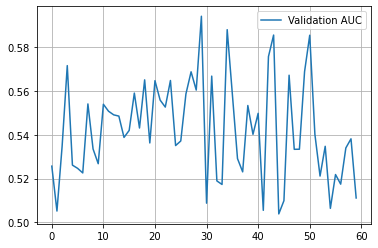

In [385]:
plt.plot(gru_d_test_auc_history, label="Validation AUC")
plt.grid()
plt.legend()

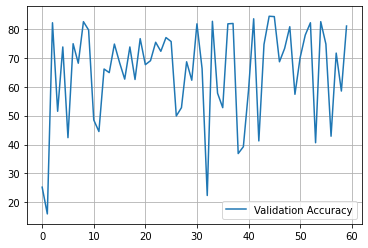

In [386]:
plt.plot(gru_d_val_acc_history, label="Validation Accuracy")
plt.grid()
plt.legend()

In [387]:
print("\t\t Best AUC: %.4f" % np.max(gru_d_test_auc_history))
print("\t\t Best Accuracy: %.4f" % np.max(gru_d_val_acc_history))

		 Best AUC: 0.5942
		 Best Accuracy: 84.3750


$$ decay =  \frac{arctan(x)+\frac{\pi}{2}}{\pi}$$

In [392]:
import math

class GRUD(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 gru_dropout=0.3, decoder_dropout=0.5, batch_first=True):
        super(GRUD, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_first = batch_first
#         self.feature_means = Variable(torch.FloatTensor(feature_means), requires_grad=False)
        # initialize weights and biases
        self.W_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_r = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_r = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_r = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U_z = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V_z = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_z = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        self.W = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.U = nn.Parameter(torch.FloatTensor(hidden_size, hidden_size).normal_(0, 0.02))
        self.V = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b = nn.Parameter(torch.FloatTensor(hidden_size).zero_())

        # since W_gamma_x is diagonal, just initialize 1-d
        self.W_gamma_x = nn.Parameter(torch.FloatTensor(input_size).normal_(0, 0.02))
        self.b_gamma_x = nn.Parameter(torch.FloatTensor(input_size).zero_())

        self.W_gamma_h = nn.Parameter(torch.FloatTensor(input_size, hidden_size).normal_(0, 0.02))
        self.b_gamma_h = nn.Parameter(torch.FloatTensor(hidden_size).zero_())
        self.gru_dropout = gru_dropout
        
        self.decoder = nn.Linear(hidden_size, output_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.decoder_dropout = nn.Dropout(p=decoder_dropout)
        self.register_buffer('X_last_obs', torch.zeros(input_size))
        
    def forward(self, x, delta, m, h_t=None):
        """
        
        :param x: features input [batch_size, seq_len, num_features]
        :param delta: time interval of feature observation [batch_size, seq_len, num_features]
        :param m: masking vector {0, 1} of [batch_size, seq_len, num_features]
        :param x_forward: place to replace missing values with [b, seqlen, numf]
        :param h_t: initial hidden state [batch_size, seq_len, hidden_size]
        :return: output [batch_size, output_size], hidden_state [batch_size, hidden_size]
        """
        batch_size, seq_len, input_size = x.size()
        
        x_forward = getattr(self, 'X_last_obs')
        
        if h_t is None:
            # initialize to zero
            h_t = Variable(torch.FloatTensor(batch_size, self.hidden_size).zero_())
            if x.is_cuda:
                h_t = h_t.cuda()
          
        # compute decays
        decay_x = delta*self.W_gamma_x + self.b_gamma_x
        zeroes = Variable(torch.zeros(decay_x.size()))
        if decay_x.is_cuda:
            zeroes = zeroes.cuda()
        #gamma_x_t = torch.exp(-torch.max(zeroes, decay_x))
        gamma_x_t = (torch.arctan(decay_x) + torch.Tensor([math.pi]).cuda()/2)/torch.Tensor([math.pi]).cuda()
            
        decay_h = torch.matmul(m, self.W_gamma_h) + self.b_gamma_h
        zeroes = Variable(torch.zeros(decay_h.size()))
        if decay_h.is_cuda:
            zeroes = zeroes.cuda()
        # gamma_x_h = torch.exp(-torch.max(zeroes, decay_h))
        gamma_x_h = (torch.arctan(decay_h) + torch.Tensor([math.pi]).cuda()/2)/torch.Tensor([math.pi]).cuda()
        
        # replace missing values
        x_replace = decay_x * x_forward + (1-decay_x) * 0.001
        x[m.byte()] = x_replace[m.byte()]
                  
        # dropout masks, one for each batch
        dropout_rate = self.gru_dropout if self.training else 0.
        
        W_dropout = Variable((torch.FloatTensor(self.W.size()).uniform_() > dropout_rate).float())
        U_dropout = Variable((torch.FloatTensor(self.U.size()).uniform_() > dropout_rate).float())
        V_dropout = Variable((torch.FloatTensor(self.V.size()).uniform_() > dropout_rate).float())
        
        if decay_h.is_cuda:
            W_dropout = W_dropout.cuda()
            U_dropout = U_dropout.cuda()
            V_dropout = V_dropout.cuda()
        
        for t in range(seq_len):
            # decay h
            update_range = Variable(torch.LongTensor(list(range(batch_size))))
            if decay_h.is_cuda:
                update_range = update_range.cuda()
            h_t = h_t.clone().index_copy_(0, update_range, gamma_x_h[:batch_size,t,:] * h_t[:batch_size])

            z_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_z) + torch.matmul(h_t[:batch_size], self.U_z) + torch.matmul(1-m[:batch_size, t, :], self.V_z) + self.b_z)
            r_t = F.sigmoid(torch.matmul(x[:batch_size, t, :], self.W_r) + torch.matmul(h_t[:batch_size], self.U_r) + torch.matmul(1-m[:batch_size, t, :], self.V_r) + self.b_r)
            h_tilde_t = F.tanh(torch.matmul(x[:batch_size, t, :], self.W*W_dropout) + torch.matmul(h_t[:batch_size]*r_t, self.U*U_dropout) + torch.matmul(1-m[:batch_size, t, :], self.V*V_dropout) + self.b)
            h_t = h_t.clone()
            h_t = h_t.clone().index_copy_(0, update_range, (1 - z_t) * h_t[:batch_size] + z_t * h_tilde_t)
            
        if batch_size > 1:
            h_t = self.bn(h_t)

        output = F.log_softmax(self.decoder(self.decoder_dropout(h_t)), dim=-1)
        
        return output, h_t

In [393]:
import warnings
warnings.filterwarnings("ignore")

gru_d = GRUD(NUM_FEATURES, 49, output_size, 0.0, decoder_dropout)
gru_d.cuda()

optimizer = torch.optim.Adam(gru_d.parameters(), lr=1e-3)

gru_d_train_loss_history = []
gru_d_test_auc_history = []
gru_d_val_loss_history = []
gru_d_val_acc_history = []

num_epochs = 40

for epoch in range(num_epochs):
    start = time()
    total_loss = 0.

    for i, (data, label) in enumerate(train_loader):
        x, m, delta = data[:, 0], data[:, 1], data[:, 2]

        x = Variable(x.float()).cuda()
        delta = Variable(delta.float()).cuda()
        m = Variable(m.float()).cuda()

        optimizer.zero_grad()

        output, hidden = gru_d(x, delta, m)

        label = label
        loss = loss_func(output, Variable(label.long()).cuda())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # report performance
    with torch.no_grad():
        val_acc, test_auc, val_loss = test_model_gru_d(test_loader, gru_d)
        gru_d_train_loss_history.append(total_loss/(i+1))
        gru_d_test_auc_history.append(test_auc)
        gru_d_val_acc_history.append(val_acc)
        gru_d_val_loss_history.append(val_loss)
        print('Fold: {8}, Epoch: [{0}/{1}], Step: [{2}/{3}], Loss: {4}, Validation Loss:{5}, Validation Acc:{6}, AUC:{7}'.format(
            epoch + 1, num_epochs, i + 1, len(train_loader), total_loss/(i+1), val_loss, val_acc, test_auc, k+1))
    print("Epoch %d time: %.4f" % (epoch, time()-start))

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [1/40], Step: [100/100], Loss: 0.7751727640628815, Validation Loss:0.7117587637901306, Validation Acc:20.75, AUC:0.505970131087282
Epoch 0 time: 7.9513


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [2/40], Step: [100/100], Loss: 0.7266692799329758, Validation Loss:1.1682081699371338, Validation Acc:84.875, AUC:0.5
Epoch 1 time: 8.2266


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [3/40], Step: [100/100], Loss: 0.6948839467763901, Validation Loss:0.6968388867378235, Validation Acc:38.75, AUC:0.5101327912949282
Epoch 2 time: 7.0738


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [4/40], Step: [100/100], Loss: 0.6842545330524444, Validation Loss:0.7019213724136353, Validation Acc:33.875, AUC:0.53235190301732
Epoch 3 time: 8.3583


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [5/40], Step: [100/100], Loss: 0.6766277146339417, Validation Loss:0.7521259093284607, Validation Acc:79.375, AUC:0.515141372217286
Epoch 4 time: 9.0452


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [6/40], Step: [100/100], Loss: 0.6665078896284103, Validation Loss:0.6963174962997436, Validation Acc:72.25, AUC:0.5342932606287808
Epoch 5 time: 8.3717


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [7/40], Step: [100/100], Loss: 0.6644048500061035, Validation Loss:0.6997281575202942, Validation Acc:72.25, AUC:0.5478766781484682
Epoch 6 time: 7.4063


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [8/40], Step: [100/100], Loss: 0.6512288376688957, Validation Loss:0.7075568222999573, Validation Acc:71.375, AUC:0.5393261845932885
Epoch 7 time: 8.6683


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [9/40], Step: [100/100], Loss: 0.6551822698116303, Validation Loss:0.7303702425956726, Validation Acc:76.5, AUC:0.5389549532005015
Epoch 8 time: 8.1246


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [10/40], Step: [100/100], Loss: 0.6485127571225167, Validation Loss:0.6955757236480713, Validation Acc:68.25, AUC:0.5650628659063524
Epoch 9 time: 9.7321


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [11/40], Step: [100/100], Loss: 0.6449809461832047, Validation Loss:0.6996008157730103, Validation Acc:64.375, AUC:0.5490268868900546
Epoch 10 time: 8.5378


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [12/40], Step: [100/100], Loss: 0.6371064108610153, Validation Loss:0.7629498553276062, Validation Acc:80.25, AUC:0.5169001570126219
Epoch 11 time: 7.6733


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [13/40], Step: [100/100], Loss: 0.6288347128033638, Validation Loss:0.7205616950988769, Validation Acc:70.75, AUC:0.5492277169877919
Epoch 12 time: 7.4621


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [14/40], Step: [100/100], Loss: 0.6240095347166061, Validation Loss:0.7980284261703491, Validation Acc:79.125, AUC:0.5272520356868998
Epoch 13 time: 7.4995


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [15/40], Step: [100/100], Loss: 0.6273382496833801, Validation Loss:0.7057086491584778, Validation Acc:56.125, AUC:0.5343845470368431
Epoch 14 time: 6.8356


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [16/40], Step: [100/100], Loss: 0.6175053626298904, Validation Loss:0.7285941529273987, Validation Acc:63.875, AUC:0.556268941929673
Epoch 15 time: 6.7440


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [17/40], Step: [100/100], Loss: 0.6080559581518173, Validation Loss:0.7712506067752838, Validation Acc:71.875, AUC:0.5490634014532796
Epoch 16 time: 7.2285


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [18/40], Step: [100/100], Loss: 0.602259364426136, Validation Loss:0.7448495578765869, Validation Acc:71.0, AUC:0.5439087622780219
Epoch 17 time: 7.0909


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [19/40], Step: [100/100], Loss: 0.5895120561122894, Validation Loss:0.73593599319458, Validation Acc:57.5, AUC:0.5526722574520138
Epoch 18 time: 7.3183


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [20/40], Step: [100/100], Loss: 0.5938819986581803, Validation Loss:0.9183075392246246, Validation Acc:80.75, AUC:0.5334290826324566
Epoch 19 time: 7.9433


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [21/40], Step: [100/100], Loss: 0.5724244818091393, Validation Loss:0.746475248336792, Validation Acc:53.75, AUC:0.5645394905001279
Epoch 20 time: 7.4008


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [22/40], Step: [100/100], Loss: 0.577660682797432, Validation Loss:0.7685443353652954, Validation Acc:50.75, AUC:0.5434705875193223
Epoch 21 time: 7.2618


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [23/40], Step: [100/100], Loss: 0.5625106698274612, Validation Loss:0.7458320093154908, Validation Acc:58.875, AUC:0.5743558222471062
Epoch 22 time: 7.2550


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [24/40], Step: [100/100], Loss: 0.5583710414171219, Validation Loss:0.7955432653427124, Validation Acc:70.25, AUC:0.5802407526868633
Epoch 23 time: 8.5071


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [25/40], Step: [100/100], Loss: 0.5437443289160728, Validation Loss:0.8748759269714356, Validation Acc:71.875, AUC:0.5490634014532796
Epoch 24 time: 8.9013


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [26/40], Step: [100/100], Loss: 0.5417669755220413, Validation Loss:0.9482454335689545, Validation Acc:79.5, AUC:0.536252875521854
Epoch 25 time: 8.8031


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [27/40], Step: [100/100], Loss: 0.5309037408232689, Validation Loss:0.8319276094436645, Validation Acc:37.0, AUC:0.5711364549227718
Epoch 26 time: 8.5760


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [28/40], Step: [100/100], Loss: 0.5188549345731736, Validation Loss:0.8026335525512696, Validation Acc:66.875, AUC:0.5637544273907911
Epoch 27 time: 9.5457


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [29/40], Step: [100/100], Loss: 0.5243269780278206, Validation Loss:1.7552488112449647, Validation Acc:84.375, AUC:0.5038462006596964
Epoch 28 time: 7.5178


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [30/40], Step: [100/100], Loss: 0.5230894854664803, Validation Loss:1.0694250905513762, Validation Acc:82.375, AUC:0.5294185664382478
Epoch 29 time: 7.7733


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [31/40], Step: [100/100], Loss: 0.4968094423413277, Validation Loss:0.7947357702255249, Validation Acc:51.0, AUC:0.5517350503292396
Epoch 30 time: 7.3723


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [32/40], Step: [100/100], Loss: 0.47826609402894976, Validation Loss:0.9863018321990967, Validation Acc:78.0, AUC:0.5579790406407089
Epoch 31 time: 7.0538


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [33/40], Step: [100/100], Loss: 0.4897907903790474, Validation Loss:1.0110019898414613, Validation Acc:73.375, AUC:0.5714833432734089
Epoch 32 time: 7.0865


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [34/40], Step: [100/100], Loss: 0.462876558303833, Validation Loss:0.9372418975830078, Validation Acc:75.25, AUC:0.5893207074088048
Epoch 33 time: 7.6567


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [35/40], Step: [100/100], Loss: 0.45018268391489985, Validation Loss:1.0627381086349488, Validation Acc:33.5, AUC:0.5742888788811937
Epoch 34 time: 7.2880


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [36/40], Step: [100/100], Loss: 0.439476530700922, Validation Loss:1.1583831775188447, Validation Acc:78.25, AUC:0.5696393578305481
Epoch 35 time: 7.5716


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [37/40], Step: [100/100], Loss: 0.4238320091366768, Validation Loss:0.9531778752803802, Validation Acc:65.875, AUC:0.5748426830901058
Epoch 36 time: 7.2606


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [38/40], Step: [100/100], Loss: 0.40632708549499513, Validation Loss:1.1484762477874755, Validation Acc:74.5, AUC:0.5611314645991309
Epoch 37 time: 7.3241


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [39/40], Step: [100/100], Loss: 0.3905520896613598, Validation Loss:1.23357568025589, Validation Acc:73.375, AUC:0.544316508234034
Epoch 38 time: 7.7915


[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (function expandTensors)
[W IndexingUtils.h:30] Warning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool inste

Fold: 1, Epoch: [40/40], Step: [100/100], Loss: 0.3654730933904648, Validation Loss:2.5142253279685973, Validation Acc:84.0, AUC:0.49824121520466413
Epoch 39 time: 7.1526


In [394]:
print("\t\t Best AUC: %.4f" % np.max(gru_d_test_auc_history))
print("\t\t Best Accuracy: %.4f" % np.max(gru_d_val_acc_history))

		 Best AUC: 0.5893
		 Best Accuracy: 84.8750
